In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

f = h5py.File('nyu_depth_v2_labeled.mat','r')
data = f.get('images')
data = np.array(data).transpose() # For converting to a NumPy array
depth = f.get('depths')
depth = np.array(depth).transpose()

In [2]:
#Preprocessing

data, depth = np.moveaxis(data,-1,0), np.moveaxis(depth,-1,0)
data, depth = data[:,80:400,100:500,:], depth[:,80:400,100:500]
data, depth = data/255, depth/depth.max()

print(data.shape)
print(depth.shape)


(1449, 320, 400, 3)
(1449, 320, 400)


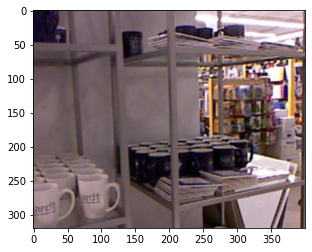

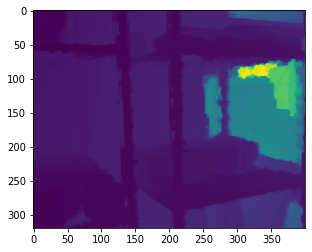

In [3]:
imgplot = plt.imshow(data[100,:,:,:])
plt.show()
imgplot = plt.imshow(depth[100,:,:])
plt.show()


In [4]:
#reducing dataset
ind = np.random.choice(range(data.shape[0]), size=(1200,), replace=False)
reduced_data = data[ind,:,:,:]
reduced_depths = depth[ind,:,:]


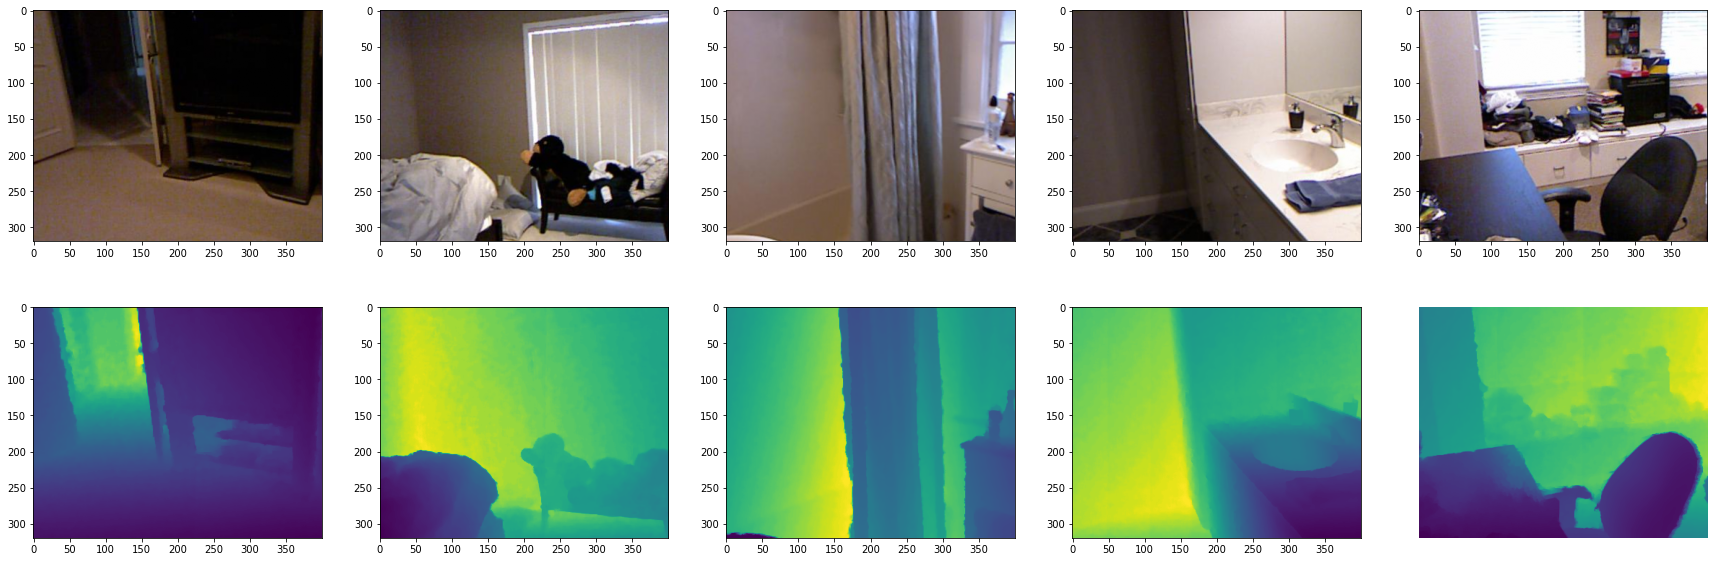

In [5]:
# split dataset to x_train y_train and x_test y_test
choice = np.random.choice(range(reduced_data.shape[0]), size=(1000,), replace=False)    
ind = np.zeros(reduced_data.shape[0], dtype=bool)
ind[choice] = True
rest = ~ind

x_train, y_train = reduced_data[ind,:,:,:], reduced_depths[ind,:,:]
x_test, y_test = reduced_data[rest,:,:,:],reduced_depths[rest,:,:]

f, ax = plt.subplots(2,5,figsize=(30, 10))
a = 0
for i in range(5):
  
  ax[0,a].imshow(x_train[i,:,:,:])
  ax[1,a].imshow(y_train[i,:,:])
  plt.axis("off")
  a+=1


In [6]:
print('x_train shape: ',x_train.shape,'/ x_test shape: ',x_test.shape)
print('y_train shape: ',y_train.shape,'/ y_test shape: ',y_test.shape)


x_train shape:  (1000, 320, 400, 3) / x_test shape:  (200, 320, 400, 3)
y_train shape:  (1000, 320, 400) / y_test shape:  (200, 320, 400)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, Flatten, Reshape, Conv2DTranspose, LeakyReLU, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# CliffNet Module for Feature Fusion
def Cliff_module(high_level,low_level):
    x = Conv2DTranspose(low_level.shape[3],(3,3),strides=2, padding='same')(high_level)
    x = BatchNormalization()(x)
    high = LeakyReLU(alpha=0.2)(x)
    multiplied = tf.keras.layers.Multiply()([high,low_level])

    concat = tf.keras.layers.Concatenate(axis=-1)([multiplied, low_level])
    x = Conv2D(high.shape[3],(3,3),padding='same')(concat)
    x = BatchNormalization()(x)
    x =  LeakyReLU(alpha=0.2)(x)
    concat_2 = tf.keras.layers.Concatenate(axis=-1)([x, high])
    x = Conv2D(high.shape[3],(3,3),padding='same')(concat_2)
    x = BatchNormalization()(x)
    x =  LeakyReLU(alpha=0.2)(x)

    return tf.keras.layers.Add()([x,high])


In [9]:
#Hyperparameters
H,W,C = 320,400,3
latent_dim = 128
epoch = 10
batch_size=8
lr = 0.01

inputs = Input(shape=(H,W,C))
x = inputs
######### Encoder ##########
#layer 1 (160,200,16)
x = Conv2D(16,(3,3),padding='same')(x)  
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x_enc_l1 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)

x = Conv2D(32,(3,3),padding='same')(x_enc_l1) #lateral connection layer (160,200,16)
x = BatchNormalization()(x)
x_int_l1 =  LeakyReLU(alpha=0.2)(x)

#layer 2 (80,100,32)
x = Conv2D(32,(3,3),padding='same')(x_enc_l1)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x_enc_l2 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


x = Conv2D(64,(3,3),padding='same')(x_enc_l2) #lateral connection layer (80,100,64)
x = BatchNormalization()(x)
x_int_l2 = LeakyReLU(alpha=0.2)(x)


#layer 3 (40,50,64)
x = Conv2D(64,(3,3),padding='same')(x_enc_l2)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x_enc_l3 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


x = Conv2D(64,(3,3),padding='same')(x_enc_l3) #lateral connection layer (40,50,64)
x = BatchNormalization()(x)
x_int_l3 = LeakyReLU(alpha=0.2)(x)

#layer 4 (20,25,64)
x = Conv2D(64,(3,3),padding='same')(x_enc_l3)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x_enc_l4 = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)


x = Conv2D(64,(3,3),padding='same')(x_enc_l4)#lateral connection layer (20,25,64)
x = BatchNormalization()(x)
x_int_l4 = LeakyReLU(alpha=0.2)(x)
################################
######### Decoder ##############
x = Conv2DTranspose(64,(3,3),strides=2, padding='same')(x_int_l4) #(40,50,64)
x = BatchNormalization()(x)
x_dec_l1 = LeakyReLU(alpha=0.2)(x)

x_con_1 = tf.keras.layers.Concatenate(axis=-1)([x_int_l3, x_dec_l1])     #(40,50,64)
x_cliff_1 = Cliff_module(x_int_l4,x_con_1)
x = Conv2DTranspose(64,(3,3),strides=2, padding='same')(x) #(80,100,64)
x = BatchNormalization()(x)
x_dec_l2 = LeakyReLU(alpha=0.2)(x) 

x_con_2 = tf.keras.layers.Concatenate(axis=-1)([x_int_l2, x_dec_l2])     #(40,50,64)
x_cliff_2 = Cliff_module(x_cliff_1,x_con_2)
x = Conv2DTranspose(32,(3,3),strides=2, padding='same')(x)
x = BatchNormalization()(x)
x_dec_l3 = LeakyReLU(alpha=0.2)(x)

x_con_3 = tf.keras.layers.Concatenate(axis=-1)([x_int_l1, x_dec_l3])
x_cliff_3 = Cliff_module(x_cliff_2,x_con_3)
x = Conv2DTranspose(16,(3,3),strides=2, padding='same')(x_cliff_3)
x = BatchNormalization()(x)
x_dec_l4 = LeakyReLU(alpha=0.2)(x)



x = Conv2DTranspose(1,(3,3), padding='same')(x_dec_l4)
x = Activation("sigmoid")(x)

out = x
#decoder = Model(enc_out,out)
#decoder.summary()
autoencoders = Model(inputs,out)
autoencoders.compile(optimizer = Adam(lr), loss="mse",metrics=['accuracy'])
autoencoders.summary(line_length=150)


Model: "model"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                     Param #           Connected to                                      
 input_1 (InputLayer)                            [(None, 320, 400, 3)]            0                 []                                                
                                                                                                                                                      
 conv2d (Conv2D)                                 (None, 320, 400, 16)             448               ['input_1[0][0]']                                 
                                                                                                                                                      
 batch_normalization (BatchNormalization)        (None, 320, 400, 16)          

In [10]:
history = autoencoders.fit(x_train,y_train,epochs=epoch,batch_size=batch_size,validation_split=0.1)

Epoch 1/10
113/113 [==============================] - 989s 9s/step - loss: 0.0234 - accuracy: 0.0000e+00 - val_loss: 0.1019 - val_accuracy: 0.0000e+00
Epoch 2/10
113/113 [==============================] - 1127s 10s/step - loss: 0.0216 - accuracy: 0.0000e+00 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 3/10
113/113 [==============================] - 1044s 9s/step - loss: 0.0214 - accuracy: 0.0000e+00 - val_loss: 0.0194 - val_accuracy: 0.0000e+00
Epoch 4/10
113/113 [==============================] - 1055s 9s/step - loss: 0.0211 - accuracy: 0.0000e+00 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 5/10
113/113 [==============================] - 721s 6s/step - loss: 0.0203 - accuracy: 0.0000e+00 - val_loss: 0.0254 - val_accuracy: 0.0000e+00
Epoch 6/10
113/113 [==============================] - 712s 6s/step - loss: 0.0198 - accuracy: 0.0000e+00 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 7/10
113/113 [==============================] - 702s 6s/step - loss: 0.0187 - accura

In [11]:
out_pre = autoencoders.predict(x_test)

7/7 [==============================] - 45s 7s/step


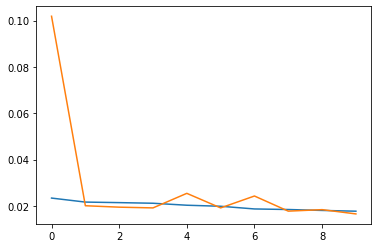

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


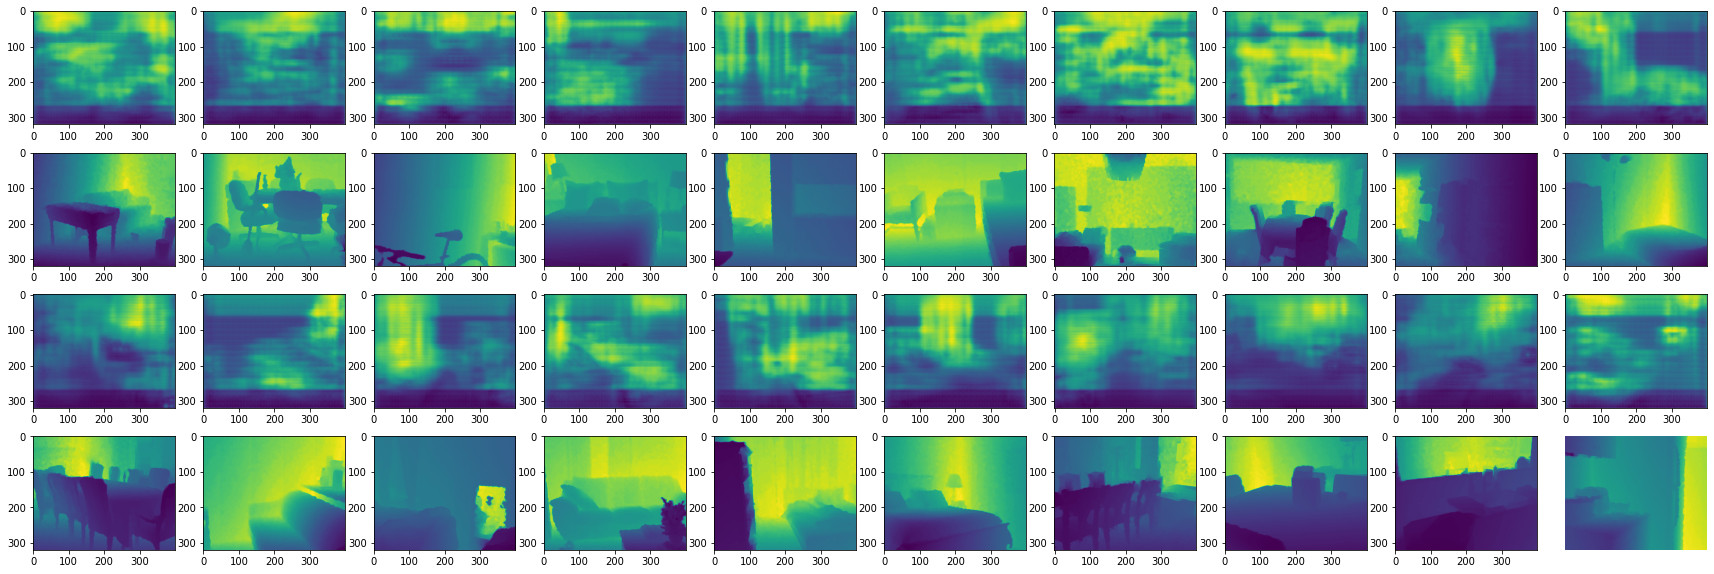

In [13]:
f, ax = plt.subplots(4,10,figsize=(30, 10))
a = 0
for i in range(10):
  
    ax[0,i].imshow(out_pre[i+100])
    ax[0,i].set_title('estimated')

    ax[1,i].imshow(y_test[i+100])
    ax[1,i].set_title('Ground Truth')

    ax[2,i].imshow(out_pre[i+90])
    ax[2,i].set_title('estimated')

    ax[3,i].imshow(y_test[i+90])
    ax[3,i].set_title('Ground Truth')
    plt.axis("off")
